In [1]:
import formating       #need to import functions to use them 
import analysis
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import xlwings as xw

Main functions using the helper functions in analysis.py and formating.py. They are written here to give examples of how to use helper functions to do sepcific tasks not covered in the main functions. 

In [2]:
def prepare_file_df(relative_file_path, remove_filters, aminos_to_count, add_pks, make_wide):
    '''
    input: 
        to_remove: which columns to consider for row filter and value to filter for. REQUIRED FORMAT [(col_name, wanted_value), ...]
        aminos_to_count: list of which animo acides to added column of their count for if any. REQUIRED FORMAT: [captical_amino_code,...]
        add_pks: REQUIRED FORMAT=(bool_1, bool_2). bool_1 true if want to add column with pKa of crd3 region, bool_2 is trim_heavy input value. 
        make_wide: [boolean, [needed_chain_types]]. True if need change format to wide, false if already wide.  
    output: 
        final_df: the df made based on all processing details. 
    '''
    df = pd.read_csv(relative_file_path)
    for i, (col_name, wanted_value) in enumerate(remove_filters):
        df = formating.remove_rows(df, col_name, wanted_value)
    if make_wide[0]: 
        df = formating.make_combined_rows(df, make_wide[1])
    for amino in aminos_to_count: 
        formating.amino_acid_count(df, amino)
    if add_pks[0]: 
        formating.crd3_pKa(df, add_pks[1])
    return df 

In [ ]:
#YEAH YOU NEED TO CHANGE A LOT IN THIS... BUT COME BACK TO IT ONCE THE CODE CAN ACTUALLY DO WHAT IS NEEDS TO FIRST 
from collections import Counter
PKA_VALUES = {'R': 12.48, 'D': 3.65, 'C': 8.18, 'H': 6, 'K': 10.53, 'E': 4.25, 'Y': 10.07}
def optimized_prepare_file_df(relative_file_path, remove_filters, aminos_to_count, add_pks, make_wide):
    '''
    input: 
        to_remove: which columns to consider for row filter and value to filter for. REQUIRED FORMAT [(col_name, wanted_value), ...]
        aminos_to_count: list of which animo acides to added column of their count for if any. REQUIRED FORMAT: [captical_amino_code,...]
        add_pks: REQUIRED FORMAT=(bool_1, bool_2). bool_1 true if want to add column with pKa of crd3 region, bool_2 is trim_heavy input value. 
        make_wide: [boolean, [needed_chain_types]]. True if need change format to wide, false if already wide.  
    output: 
        final_df: the df made based on all processing details. 
    '''
    df = pd.read_csv(relative_file_path)
    mask = True
    for col_name, wanted_value in remove_filters:
        mask &= df[col_name] == wanted_value
    df = df[mask]
    if make_wide[0]: 
        df = formating.make_combined_rows(df, make_wide[1])
    new_cols = {}
    for col in [c for c in df.columns if c.endswith("cdr3")]:
        seqs = df[col].apply(lambda x: x[3:] if isinstance(x, str) and col.startswith("IGH") else x)
        counts_series = seqs.map(lambda s: Counter(s) if isinstance(s, str) else {})
        for amino in aminos_to_count:
            new_cols[f"{col[:3]}_{amino}_count"] = counts_series.map(lambda c: c.get(amino, 0))
        if add_pks[0]:
            new_cols[f"{col[:4]}_cdr3_pKa"] = counts_series.map(
                lambda c: sum(c.get(aa, 0) * pka for aa, pka in PKA_VALUES.items())
            )
    df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    print("Done with one!")
    return df 

Going through questions based on flow chart made with Peter!

In [19]:
#maybe come back and make a function that can do this....
#pulling all data from csv files and formating so that analysis can be done on them 
directory = r"C:\Users\tskal\OneDrive\Desktop\Working for Mama!\data\files naive"
file_name_info = []
for path, folders, files in os.walk(directory):
    for filename in files: 
        file_path = "data/files naive/"+filename
        fkey = filename[:3]+filename[4]
        file_name_info.append([fkey, file_path])
dfs = { k: optimized_prepare_file_df(p, [('productive', True)], ['R'], (True, True), [True, ['IGH', 'IGK', 'IGL']])
    for k, p in file_name_info}  #ask and maybe add back ('is_naive', 'Naive')
all_igh, all_iglk = analysis.all_heavyLight_genes(dfs, ['v_gene', 'j_gene', 'd_gene'])

Done with one!
Done with one!
Done with one!
Done with one!
Done with one!
Done with one!


In [2]:
directory = r"C:\Users\tskal\OneDrive\Desktop\Working for Mama!\data\files naive"
file_name_info = []
for path, folders, files in os.walk(directory):
    for filename in files: 
        file_path = "data/files naive/"+filename
        fkey = filename[:3]+filename[4]
        file_name_info.append([fkey, file_path])
dfs = {}
for k, path in file_name_info:  #ask and maybe add back ('is_naive', 'Naive')
    cur_df = pd.read_csv(path)
    cur_df = formating.remove_rows(cur_df, 'productive', True) #CHANGE THIS FUNCTION, SLOW BAD BOO
    cur_df = formating.remove_rows(cur_df, 'is_naive', 'Naive')
    cur_df = formating.make_combined_rows(cur_df, ['IGH', 'IGK', 'IGL'])
    # og_count_df = analysis.get_gene_counts_df(cur_df, ['v_gene', 'j_gene', 'd_gene'])
    # cur_df = formating.remove_by_threshold(cur_df, og_count_df, 0.05)
    formating.amino_acid_count(cur_df, 'R')
    formating.crd3_pKa(cur_df)
    dfs[k] = cur_df
all_igh, all_iglk = analysis.all_heavyLight_genes(dfs, ['v_gene', 'j_gene', 'd_gene'])

In [3]:
#FIRST QUESTION: Is the relative abundance of Heavy Chain genes different between healthy and SLE samples? DO A T-TEST OF RELTIVE ABUNDANCE OF EACH 
h_rel_abundance = []
sle_rel_abundance = []
for k in dfs.keys(): 
    heavy_counts = analysis.relative_abundance_df(dfs[k], ['v_gene', 'j_gene', 'd_gene'], ['IGH'], all_igh)
    if k.startswith('hcd'):
        h_rel_abundance.append(heavy_counts)
    else: 
        sle_rel_abundance.append(heavy_counts)
heavy_rel_abundance_ttest_df = analysis.t_test(sle_rel_abundance,h_rel_abundance, all_igh)
heavy_rel_abundance_ttest_df = formating.sortCols_byGenes(heavy_rel_abundance_ttest_df, 6, 'Gene')
print(heavy_rel_abundance_ttest_df[heavy_rel_abundance_ttest_df['Equal Population Variance p_values'] <= 0.05])
print(heavy_rel_abundance_ttest_df[heavy_rel_abundance_ttest_df['Welch p_values'] <= 0.05])

        Gene  Equal Population Variance t_stats  \
11  IGHD2-15                          -5.256134   
8    IGHV1-2                          -3.286203   
40  IGHV2-70                          -3.566094   
3   IGHV3-13                           3.021724   
5   IGHV3-48                           3.288595   
22  IGHV3-53                           4.813342   

    Equal Population Variance p_values  Welch t_stats  Welch p_values  
11                            0.006271      -5.256134        0.006720  
8                             0.030323      -3.286203        0.053939  
40                            0.023458      -3.566094        0.059064  
3                             0.039097       3.021724        0.066965  
5                             0.030255       3.288595        0.068032  
22                            0.008564       4.813342        0.013205  
        Gene  Equal Population Variance t_stats  \
11  IGHD2-15                          -5.256134   
22  IGHV3-53                        

In [4]:
h_light_abund = []
sle_light_abund = []
for k in dfs.keys(): 
    all_gene_counts = analysis.get_gene_counts_df(dfs[k], ['v_gene', 'j_gene', 'd_gene'])
    light_counts = all_gene_counts[all_gene_counts['gene'].str.startswith('IGL') | all_gene_counts['gene'].str.startswith('IGK')]
    missing_ighs_df = pd.DataFrame({
        'gene': list(set(all_iglk) - set(light_counts['gene'].unique())), 
        'count': 0})
    light_counts = pd.concat([light_counts, missing_ighs_df], ignore_index=True)
    light_counts = formating.sortCols_byGenes(light_counts, 6, 'gene')
    light_counts['rel_freq'] = light_counts['count']/light_counts['count'].sum()*100
    light_counts = light_counts.set_index('gene')
    if k.startswith('hcd'):
        h_light_abund.append(light_counts)
    else: 
        sle_light_abund.append(light_counts)
light_rel_abundance_ttest_df = analysis.t_test(h_light_abund, sle_light_abund, all_iglk)
light_rel_abundance_ttest_df = formating.sortCols_byGenes(light_rel_abundance_ttest_df, 6, 'Gene')
print(light_rel_abundance_ttest_df[light_rel_abundance_ttest_df['Equal Population Variance p_values'] <= 0.05])
print(light_rel_abundance_ttest_df[light_rel_abundance_ttest_df['Welch p_values'] <= 0.05])

        Gene  Equal Population Variance t_stats  \
26     IGKJ3                           6.190426   
72  IGKV1-16                          -2.902666   
63  IGKV3-15                          -3.896486   

    Equal Population Variance p_values  Welch t_stats  Welch p_values  
26                            0.003461       6.190426        0.005867  
72                            0.044000      -2.902666        0.044484  
63                            0.017594      -3.896486        0.054440  
        Gene  Equal Population Variance t_stats  \
26     IGKJ3                           6.190426   
72  IGKV1-16                          -2.902666   

    Equal Population Variance p_values  Welch t_stats  Welch p_values  
26                            0.003461       6.190426        0.005867  
72                            0.044000      -2.902666        0.044484  


In [ ]:
hh_light_abund = []
ssle_light_abund = []
for k in dfs.keys(): 
    light_counts = analysis.relative_abundance_df(dfs[k], ['v_gene', 'j_gene', 'd_gene'], ['IGK', 'IGL'], all_iglk)
    if k.startswith('hcd'):
        hh_light_abund.append(light_counts)
    else: 
        ssle_light_abund.append(light_counts)
light_rel_abundance_ttest_df = analysis.t_test(hh_light_abund, ssle_light_abund, all_iglk)
light_rel_abundance_ttest_df = formating.sortCols_byGenes(light_rel_abundance_ttest_df, 6, 'Gene')
print(light_rel_abundance_ttest_df[light_rel_abundance_ttest_df['Equal Population Variance p_values'] <= 0.05])
print(light_rel_abundance_ttest_df[light_rel_abundance_ttest_df['Welch p_values'] <= 0.05])
#YESSS THE RESULTS ARE THE SAME LETS GOOOO!!!

        Gene  Equal Population Variance t_stats  \
26     IGKJ3                           6.190426   
72  IGKV1-16                          -2.902666   
63  IGKV3-15                          -3.896486   

    Equal Population Variance p_values  Welch t_stats  Welch p_values  
26                            0.003461       6.190426        0.005867  
72                            0.044000      -2.902666        0.044484  
63                            0.017594      -3.896486        0.054440  
        Gene  Equal Population Variance t_stats  \
26     IGKJ3                           6.190426   
72  IGKV1-16                          -2.902666   

    Equal Population Variance p_values  Welch t_stats  Welch p_values  
26                            0.003461       6.190426        0.005867  
72                            0.044000      -2.902666        0.044484  


In [13]:
print(len(all_igh))
print(len(all_iglk))

70
79


Now doing this for ONLY NAIVE and considering R Counts and pKas!!!!

In [10]:
#time to export to excel to get a good look at everything at once!
q1_excel_format = {
    "Naive all igh": {'tables':[{'type': "one_row", 
        'tables': [
            {'data': h_rel_abundance[0], 'title':f"hcd1 Heavy Chain Abundance"}, 
            {'data': h_rel_abundance[1], 'title':f"hcd2 Heavy Chain Abundance"}, 
            {'data': h_rel_abundance[2], 'title':f"hcd3 Heavy Chain Abundance"},
            {'data': sle_rel_abundance[0], 'title':f"sle1 Heavy Chain Abundance"}, 
            {'data': sle_rel_abundance[1], 'title':f"sle2 Heavy Chain Abundance"}, 
            {'data': sle_rel_abundance[2], 'title':f"sle3 Heavy Chain Abundance"}
        ]}, 
        {'data':heavy_rel_abundance_ttest_df, 'title':f"T-Test of Heavy Chain Abundance"}
    ]}, 
    "Naive all iglk": {'tables':[{'type': "one_row", 
        'tables': [
            {'data': h_light_abund[0], 'title':f"hcd1 Light Chain Abundance"}, 
            {'data': h_light_abund[1], 'title':f"hcd2 Light Chain Abundance"}, 
            {'data': h_light_abund[2], 'title':f"hcd3 Light Chain Abundance"},
            {'data': sle_light_abund[0], 'title':f"sle1 Light Chain Abundance"}, 
            {'data': sle_light_abund[1], 'title':f"sle2 Light Chain Abundance"}, 
            {'data': sle_light_abund[2], 'title':f"sle3 Light Chain Abundance"}
        ]}, 
        {'data':light_rel_abundance_ttest_df, 'title':f"T-Test of Light Chain Abundance"}
    ]}
}
formating.all_to_excel(q1_excel_format, "q1_analysis")

Writing sheet: Naive all igh
Writing sheet: Naive all iglk


Testing functions on just one for starters!

In [6]:
#getting and formating data
file_name = 'data/files naive/hcd_1_is_naive.csv'
df = pd.read_csv(file_name)
df = formating.remove_rows(df, 'productive', True)
df = formating.remove_rows(df, 'is_naive', "Naive")
wide_df = formating.make_combined_rows(df, ['IGH', 'IGK', 'IGL'])
formating.amino_acid_count(wide_df, 'R') #adding in new rows
formating.crd3_pKa(wide_df)
gene_counts_df = analysis.get_gene_counts_df(wide_df, ['v_gene', 'j_gene', 'd_gene'])
trim_df = formating.remove_by_threshold(wide_df, gene_counts_df, 0.05)
all_igh, all_iglk = analysis.all_heavyLight_genes([trim_df], ['v_gene', 'j_gene', 'd_gene'])
#getting binomial distribution (DO THIS FOR EACH SUBJECT SEPERATLY!)
relRfreq_df = analysis.lightChain_vs_heavyRcount_relFrequency(trim_df, all_iglk, 'IGH_R_count')
all_gene_counts = analysis.get_gene_counts_df(trim_df, ['v_gene', 'j_gene', 'd_gene'])
relRfreq_df = formating.sortCols_byGenes(relRfreq_df, 6, "light_gene")
relF_biDist_df = analysis.binomalDist(relRfreq_df, "Rcount_equalTo_0", "total", "R_equal_0_freq")

KeyboardInterrupt: 

In [13]:
#testing that normalize_pairMatrix is working correctly
pairCounts_df = analysis.get_pair_counts(trim_df, ['v_gene', 'j_gene', 'd_gene'])
pairCounts_df.columns
pairMatrix_df = formating.pairDf_to_Matrix(pairCounts_df, all_igh, all_iglk)
normalizedPair_df = analysis.normalize_pairMatrix(pairMatrix_df)

Um doing something that might not be needed yet...

In [3]:
#maybe come back and make a function that can do this....
#pulling all data from csv files and formating so that analysis can be done on them 
directory = r"C:\Users\tskal\OneDrive\Desktop\Working for Mama!\data\files naive"
file_name_info = []
for path, folders, files in os.walk(directory):
    for filename in files: 
        file_path = "data/files naive/"+filename
        fkey = filename[:3]+filename[4]
        file_name_info.append([fkey, file_path])
dfs = {}
for k, p in file_name_info:
    dfs[k] = prepare_file_df(p, [('productive', True), ('is_naive', 'Naive')], ['R'], (True, True),[True, ['IGH', 'IGK', 'IGL']])
all_igh, all_iglk = analysis.all_heavyLight_genes(dfs, ['v_gene', 'j_gene', 'd_gene'])

In [4]:
#getting binomial distribution FOR EACH SUBJECT SEPERATLY 
bino_dists = {}
for k in dfs.keys(): 
    relRfreq_df = analysis.lightChain_vs_heavyRcount_relFrequency(dfs[k], all_iglk, 'IGH_R_count')
    all_gene_counts = analysis.get_gene_counts_df(dfs[k], ['v_gene', 'j_gene', 'd_gene'])
    relRfreq_df = formating.sortCols_byGenes(relRfreq_df, 6, "light_gene")
    relF_biDist_df = analysis.binomalDist(relRfreq_df, "Rcount_equalTo_0", "total", "R_equal_0_freq")
    bino_dists[k] = relF_biDist_df

In [5]:
#formating data to do t_test 
sle_keys = []
h_keys = []
for k in dfs.keys(): 
    if k.startswith("sle"):
        sle_keys.append(k)
    else: 
        h_keys.append(k)
sle_pairMs = []
h_pairMs = []
for i in range(len(sle_keys)):
    sle_pairCount_df = analysis.get_pair_counts(dfs[sle_keys[i]], ['v_gene', 'j_gene', 'd_gene'])
    sle_pairMs.append(formating.pairDf_to_Matrix(sle_pairCount_df, all_igh, all_iglk))
    h_pairCount_df = analysis.get_pair_counts(dfs[h_keys[i]], ['v_gene', 'j_gene', 'd_gene'])
    h_pairMs.append(formating.pairDf_to_Matrix(h_pairCount_df, all_igh, all_iglk))
#running the t_test 
t_results_df = analysis.t_test_matrix(h_pairMs, sle_pairMs, all_igh, all_iglk)
print(t_results_df)
formed_t_results_df = formated_t_df = formating.pairDf_to_Matrix(t_results_df.drop('t_stats', axis=1).rename(columns={'p_values': 'Pair Count'}), all_igh, all_iglk)
formed_t_results_df

c:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


             IGH      IGKL   t_stats  p_values
0       IGHV1-45  IGLV3-10       NaN       NaN
1      IGHV3-64D  IGLV3-10  1.000000  0.373901
2       IGHD2-21  IGLV3-10 -1.000000  0.373901
3       IGHV3-23  IGLV3-10 -0.395945  0.712357
4       IGHV3-30  IGLV3-10  1.666656  0.170911
...          ...       ...       ...       ...
5525    IGHD3-16     IGLJ7       NaN       NaN
5526    IGHV4-34     IGLJ7       NaN       NaN
5527  IGHV1-69-2     IGLJ7       NaN       NaN
5528  IGHV4-30-2     IGLJ7       NaN       NaN
5529     IGHV3-7     IGLJ7       NaN       NaN

[5530 rows x 4 columns]


IGH,IGHD1-26,IGHD2-15,IGHD2-2,IGHD2-21,IGHD2-8,IGHD3-10,IGHD3-16,IGHD3-22,IGHD3-3,IGHD3-9,...,IGHV4-31,IGHV4-34,IGHV4-39,IGHV4-4,IGHV4-59,IGHV4-61,IGHV5-10-1,IGHV5-51,IGHV6-1,IGHV7-4-1
IGKL,,,,,,,,,,,,,,,,,,,,,
IGKJ1,0.664402,0.008127,0.741040,0.168041,0.395747,0.703869,0.387124,0.253037,0.249891,0.790555,...,0.720877,0.148649,0.725399,0.304680,0.167900,0.344366,0.339189,0.659533,0.985934,0.373901
IGKJ2,0.511657,0.005126,0.391738,0.269397,0.351774,0.313521,0.669409,0.245779,0.329717,0.794368,...,0.448783,0.143491,0.881702,0.796907,0.592688,0.820111,0.357361,0.550274,0.012803,0.239883
IGKJ3,0.373901,0.004678,0.491274,0.675281,0.373901,0.710242,0.464530,0.664473,0.445104,0.486366,...,0.735083,0.691389,0.628318,0.185974,0.208410,0.653537,0.336808,0.893785,0.117269,0.373901
IGKJ4,0.373901,0.016066,0.176847,0.799350,0.973146,0.339166,0.711954,0.923857,0.230259,0.314379,...,0.853158,0.026171,0.829648,0.125136,0.300059,0.597930,0.386263,0.160711,0.924247,0.373901
IGKJ5,0.373901,0.259357,0.846809,0.010283,0.162886,0.210324,0.321596,0.121987,0.903512,0.727981,...,0.162886,0.987475,0.800583,0.165273,0.392158,0.959446,0.778715,0.125951,0.837774,0.373901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGLV6-57,NaN,0.373901,0.559129,0.200560,NaN,0.143857,0.373901,0.846705,0.373901,0.396442,...,NaN,0.206799,0.139832,0.373901,0.261948,0.373901,NaN,0.243822,0.373901,NaN
IGLV7-43,NaN,0.607494,NaN,NaN,NaN,0.373901,NaN,0.373901,NaN,0.373901,...,NaN,0.619712,NaN,NaN,0.373901,0.827565,NaN,0.265683,NaN,0.373901
IGLV7-46,NaN,0.149682,0.493672,NaN,0.373901,0.320436,0.149682,0.844350,0.776840,NaN,...,NaN,NaN,0.265063,0.373901,0.149682,0.373901,0.373901,NaN,NaN,NaN


In [17]:
sle_bD_dfs = [bino_dists[sle_keys[i]] for i in range(len(sle_keys))]
h_bD_dfs = [bino_dists[h_keys[i]] for i in range(len(h_keys))]

In [7]:
#getting binomial distribution FOR COMBINED SLE AND HEALTHY 
h_totals_df = h_bD_dfs[0].copy()
h_totals_df = h_totals_df.drop(columns=['total', 'R_gt_0_freq','R_equal_0_freq', 'Binomial_Dist_sf'])
h_totals_df["Rcount_equalTo_0"] += h_bD_dfs[1]['Rcount_equalTo_0'] + h_bD_dfs[2]['Rcount_equalTo_0'] 
h_totals_df["Rcount_gt_0"] += h_bD_dfs[1]['Rcount_gt_0'] + h_bD_dfs[2]['Rcount_gt_0'] 
h_totals_df["Total"] = h_totals_df["Rcount_equalTo_0"] + h_totals_df["Rcount_gt_0"]
h_totals_df['R_gt_0_freq'] = h_totals_df['Rcount_gt_0']/h_totals_df['Total'] *100
h_totals_df['R_equal_0_freq'] = h_totals_df['Rcount_equalTo_0']/h_totals_df['Total'] *100
h_totals_df = analysis.binomalDist(h_totals_df, "Rcount_equalTo_0", "Total", "R_equal_0_freq")
sle_totals_df = sle_bD_dfs[0].copy()
sle_totals_df = sle_totals_df.drop(columns=['total', 'R_gt_0_freq','R_equal_0_freq', 'Binomial_Dist_sf'])
sle_totals_df["Rcount_equalTo_0"] += sle_bD_dfs[1]['Rcount_equalTo_0'] + sle_bD_dfs[2]['Rcount_equalTo_0'] 
sle_totals_df["Rcount_gt_0"] += sle_bD_dfs[1]['Rcount_gt_0'] + sle_bD_dfs[2]['Rcount_gt_0'] 
sle_totals_df["Total"] = sle_totals_df["Rcount_equalTo_0"] + sle_totals_df["Rcount_gt_0"]
sle_totals_df['R_gt_0_freq'] = sle_totals_df['Rcount_gt_0']/sle_totals_df['Total'] *100
sle_totals_df['R_equal_0_freq'] = sle_totals_df['Rcount_equalTo_0']/sle_totals_df['Total'] *100
sle_totals_df = analysis.binomalDist(sle_totals_df, "Rcount_equalTo_0", "Total", "R_equal_0_freq")


In [16]:
#exporting all of this to excel so i can sanity check it with all the data showing! 
#Um reformat this so it actually looks nice... a little later tho probably 
excel_expo_format = {
    "Individual Bino Dist": {
        "tables": [{"data": bino_dists[k], "title": f"{k} Heavy Chain R Amount for Each Light Chain"}
            for k in bino_dists.keys()]}, 
    "Total Bino Dist": {"tables":[
        {"data": h_totals_df, "title": f"Total hcd Heavy Chain R Amount for Each Light Chain"}, 
        {"data": sle_totals_df, "title": f"Total sle Heavy Chain R Amount for Each Light Chain"}
     ]}, 
    "T_Test": {
        "tables": [
            *(
                {"data": sle_pairMs[i], "title": f"Pair Matrix for {sle_keys[i]}"}
                for i in range(len(sle_keys))
            ),
            *(
                {"data": h_pairMs[i], "title": f"Pair Matrix for {h_keys[i]}"}
                for i in range(len(h_keys))
            ),
            {"data": t_results_df, "title": "All T_Test Results"},
            {"data": formed_t_results_df, "title": "T_Test p_values in Matrix Form"}
        ]
    }
}
formating.all_to_excel(excel_expo_format, "stats_tests")

Writing sheet: Individual Bino Dist
Writing sheet: Total Bino Dist
Writing sheet: T_Test


In [ ]:
count = 0
needed_info = []
trimed_dfs = []
for cur_df in dfs: 
    #removing rows that are not productive or Naive 
    cur_df = utils.remove_rows(cur_df, 'productive', True)
    cur_df = utils.remove_rows(cur_df, 'is_naive', "Naive")
    #reoganizing df so that all information for on cell in on same row
    cur_grouped_df = utils.make_combined_rows(cur_df, ['IGH', 'IGK', 'IGL'])
    cur_gene_counts_df = utils.get_gene_counts_df(cur_grouped_df, ['v_gene', 'j_gene', 'd_gene'])
    trim_df = utils.remove_by_threshold(cur_grouped_df, cur_gene_counts_df, 0.05)
    #adding additional columns 
    utils.amino_acid_count(trim_df, 'R')
    utils.crd3_pKa(trim_df)
    #getting relative frequenices of heavy chain R amounts
    light_rcount_df = utils.lightChain_vs_heavyRcount_relFrequency(trim_df, needed_genes, "IGH_R_count")
    utils.add_ztest_values(light_rcount_df, ['Rcount_gt_0', 'Rcount_equalTo_0'], 'total')
    needed_info.append([fkeys[count], light_rcount_df])
    #PCIK ONE!
    dfs[count] = trim_df
    trimed_dfs.append(trim_df)
    count += 1
print(needed_info[0][1].columns)

The following light chain genes were removed: ['IGLV4-60', 'IGKV6D-21', 'IGKV3D-11', 'IGLV9-49', 'IGLJ7', 'IGKV1-39', 'IGLV5-37', 'IGLV8-61']
The following light chain genes were removed: ['IGKV3D-11', 'IGKV1D-13', 'IGKV2D-28', 'IGLV3-22']
The following light chain genes were removed: ['IGKV3D-7', 'IGKV1D-43', 'IGKV2D-26', 'IGLV4-3']
The following light chain genes were removed: ['IGKV2D-28', 'IGKV3D-11', 'IGKV1D-16', 'IGKV5-2', 'IGLV2-18', 'IGLV5-37', 'IGLJ7']
The following light chain genes were removed: ['IGKV2D-26', 'IGKV3D-11', 'IGKV5-2', 'IGLV5-39']
The following light chain genes were removed: ['IGKV3D-20', 'IGLV5-45', 'IGKV2-18', 'IGKV6D-21', 'IGKV1D-16', 'IGLV5-52']
Index(['light_gene', 'Rcount_equalTo_0', 'Rcount_gt_0', 'total', 'R_gt_0_freq',
       'R_equal_0_freq', 'zstat', 'p_value', 'significant'],
      dtype='object', name='Rcount_type')


In [6]:
h_total_df = needed_info[0][1].copy()
h_total_df = h_total_df.drop(columns=['total', 'R_gt_0_freq','R_equal_0_freq', 'zstat', 'p_value', 'significant'])
h_total_df["Rcount_equalTo_0"] += needed_info[1][1]['Rcount_equalTo_0'] + needed_info[2][1]['Rcount_equalTo_0'] 
h_total_df["Rcount_gt_0"] += needed_info[1][1]['Rcount_gt_0'] + needed_info[2][1]['Rcount_gt_0'] 
h_total_df["Total"] = h_total_df["Rcount_equalTo_0"] + h_total_df["Rcount_gt_0"]
h_total_df['R_gt_0_freq'] = h_total_df['Rcount_gt_0']/h_total_df['Total'] *100
h_total_df['R_equal_0_freq'] = h_total_df['Rcount_equalTo_0']/h_total_df['Total'] *100
utils.add_ztest_values(h_total_df, ['Rcount_gt_0', 'Rcount_equalTo_0'], 'Total')

s_total_df = needed_info[3][1].copy()
s_total_df = s_total_df.drop(columns=['total', 'R_gt_0_freq','R_equal_0_freq', 'zstat', 'p_value', 'significant'])
s_total_df["Rcount_equalTo_0"] += needed_info[4][1]['Rcount_equalTo_0'] + needed_info[5][1]['Rcount_equalTo_0'] 
s_total_df["Rcount_gt_0"] += needed_info[4][1]['Rcount_gt_0'] + needed_info[5][1]['Rcount_gt_0'] 
s_total_df["Total"] = s_total_df["Rcount_equalTo_0"] + s_total_df["Rcount_gt_0"]
s_total_df['R_gt_0_freq'] = s_total_df['Rcount_gt_0']/s_total_df['Total'] *100
s_total_df['R_equal_0_freq'] = s_total_df['Rcount_equalTo_0']/s_total_df['Total'] *100
utils.add_ztest_values(s_total_df, ['Rcount_gt_0', 'Rcount_equalTo_0'], 'Total')

excel_graph_format = {
    "Individual": {
        "tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain",
                "graph_type": "Bar","graph_name": info[0],
                "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
            for info in needed_info]}, 
    "Totals": {"tables":[
        {"data": h_total_df, "title": f"Total hcd Heavy Chain R Amount for Each Light Chain", "graph_type": "Bar","graph_name": "hcd Totals", 
         "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}, 
        {"data": s_total_df, "title": f"Total sle Heavy Chain R Amount for Each Light Chain", "graph_type": "Bar","graph_name": "sle Totals",
        "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
    ]}
}   
excel_format = {
    "Individual": {
        "tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain"}
            for info in needed_info]}, 
    "Totals": {"tables":[
        {"data": h_total_df, "title": f"Total hcd Heavy Chain R Amount for Each Light Chain"}, 
        {"data": s_total_df, "title": f"Total sle Heavy Chain R Amount for Each Light Chain"}
    ]}
}   
utils.all_to_excel(excel_format, "naive_R_stuff_ztestNums_alt")

Writing sheet: Individual
Writing sheet: Totals


YOU NEED TO TRY USING https://docs.xlwings.org/en/stable/matplotlib.html MIGHT BE GAME CHANGING!!!!!

<Axes: ylabel='IGK_v_gene'>

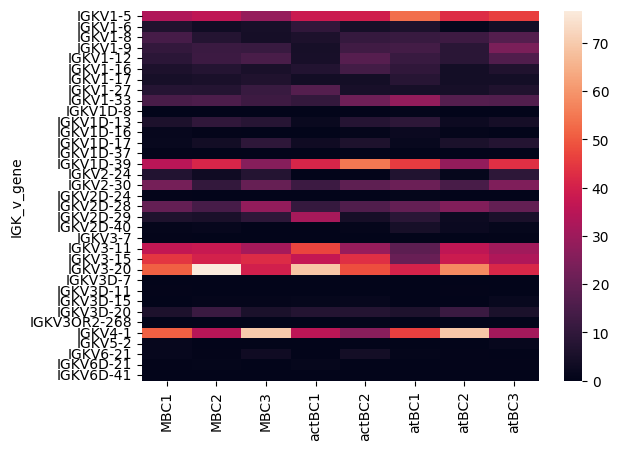

In [5]:
#HEATMAP! TODO: MAKE THIS INTO A FUNCTION HAHA 
file_name = 'data/Atypical_heavy_light_chains.csv'
df = pd.read_csv(file_name)
df = formating.remove_rows(df, 'productive', True)
all_igh, all_iglk = analysis.all_heavyLight_genes([df], ['v_gene'])
all_igl = [gene for gene in all_iglk if gene.startswith("IGL")]
all_igk = [gene for gene in all_iglk if gene.startswith("IGK")]
all_igk.sort()
ksample_df = df[['Sample', 'Celltype (Cluster)', 'IGK_v_gene']].copy().dropna(subset=['IGK_v_gene'])
data = {}
needed_cells = ["MBC1", "MBC2", "MBC3", "actBC1", "actBC2", "atBC1", "atBC2", "atBC3"]
for sample, sample_info in ksample_df.groupby("Sample"):
    samp = {}
    for cell_name, cell_info in sample_info.groupby("Celltype (Cluster)"):
        if cell_name not in needed_cells: continue
        counts = cell_info.value_counts("IGK_v_gene")
        samp[cell_name] = (counts/counts.sum()) * 100 #maybe do log2 instead?
    samp_df = pd.DataFrame.from_dict(samp).fillna(0)
    data[sample] = samp_df
con_df = pd.concat(data.values(), keys=data.keys(), names=["Sample", "IGK_v_gene"])
new_df = con_df.droplevel("Sample").groupby("IGK_v_gene").sum().reset_index()
new_df = formating.sortCols_byGenes(new_df, 6, "IGK_v_gene").set_index("IGK_v_gene")
# plt.figure(figsize=(10, 6))
ax = sns.heatmap(new_df, yticklabels=True, annot=False) 
ax
#plt.show()
# plot_path = os.path.abspath("heatmap.png")
# plt.savefig(plot_path, bbox_inches='tight')
# plt.close()
# sheet = xw.Book().sheets[0]
# print("Image saved to:", plot_path)
# print("Exists?", os.path.exists(plot_path))
# sheet.pictures.add(plot_path, name="rwar", update=True)
# os.remove(plot_path)

<Axes: ylabel='IGK_v_gene'>

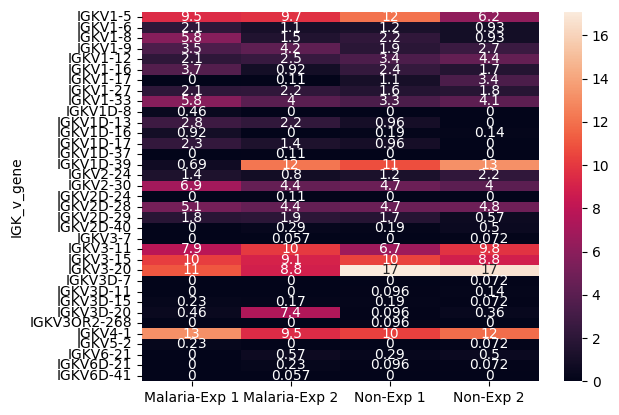

In [4]:
sample_data = {}
noNaive_df = ksample_df[ksample_df['Celltype (Cluster)'] != 'Naive']
for s_name, s_info in noNaive_df.groupby("Sample"):
    couts = s_info.value_counts("IGK_v_gene")
    sample_data[s_name] = (couts/couts.sum()) * 100
bySameple_df = pd.DataFrame.from_dict(sample_data).reset_index().fillna(0)
bySameple_df = formating.sortCols_byGenes(bySameple_df, 6, "IGK_v_gene").set_index("IGK_v_gene")
ax = sns.heatmap(bySameple_df, yticklabels=True, annot=True)
ax

In [4]:
all_igh, all_iglk = utils.all_heavyLight_genes([trim_df], ['v_gene', 'j_gene', 'd_gene'])
needed_Lgenes = [gene for gene in all_iglk if gene.startswith("IGLV") or gene.startswith("IGKV")]
needed_Lgenes.sort()
trim_totals = []
for cell_type, cell_info in trim_df.groupby("Celltype (Cluster)"):
    cell_df = utils.lightChain_vs_heavyRcount_relFrequency(cell_info, needed_Lgenes, "cdr_R_count")
    trim_totals.append([cell_type, cell_df])

Doing same analysis but for different dataset (and splitting by cell type this time)!

In [24]:
f_name = "Atypical_heavy_light_chains.csv"
g_df = pd.read_csv(f_name)
all_igh, all_iglk = utils.all_heavyLight_genes([g_df], ['v_gene', 'j_gene', 'd_gene'])
g_df = utils.remove_rows(g_df, 'productive', True)
#adding additional columns 
utils.amino_acid_count(g_df, 'R')
utils.crd3_pKa(g_df)
needed_Lgenes = [gene for gene in all_iglk if gene.startswith("IGLV") or gene.startswith("IGKV")]
needed_Lgenes.sort()
processed_samples = [] #[[name, [cell type, heavy/light R freq], [cell type, heavy/light R freq], ...], [name, ...]]
for name, sample_info in g_df.groupby("Sample"):
    sample = [name]
    for cell_type, cell_info in sample_info.groupby("Celltype (Cluster)"):
        cell_df = utils.lightChain_vs_heavyRcount_relFrequency(cell_info, needed_Lgenes, "cdr_R_count")
        sample.append([cell_type, cell_df])
    processed_samples.append(sample)

In [28]:
totals = []
for cell_type, cell_info in g_df.groupby("Celltype (Cluster)"):
    cell_df = utils.lightChain_vs_heavyRcount_relFrequency(cell_info, needed_Lgenes, "cdr_R_count")
    totals.append([cell_type, cell_df])
e_format = {}
for sample in processed_samples: 
    e_format[sample[0]] = {"tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain",
                "graph_type": "Bar","graph_name": info[0],
                "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
            for info in sample[1:]]}
e_format["Total"] = {"tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain",
                "graph_type": "Bar","graph_name": info[0],
                "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
            for info in totals]}
print("Keys in e_format:", e_format.keys())
utils.all_to_excel(e_format, "R_analysis_Atypical_heavy_light_chains")

Keys in e_format: dict_keys(['Malaria-Exp 1', 'Malaria-Exp 2', 'Non-Exp 1', 'Non-Exp 2', 'Total'])
Writing sheet: Malaria-Exp 1
Writing sheet: Malaria-Exp 2
Writing sheet: Non-Exp 1
Writing sheet: Non-Exp 2
Writing sheet: Total
